In [1]:
import warnings
warnings.filterwarnings('ignore') # Filter out warnings
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from scipy import stats
import math

In [2]:
# Create a Combined Dataframe from message csv and orderbook csv
def Merge_MsgAndOrdb(msg_path,ordb_path):
    # get the level of the LOBSTER dataset
    level = int(msg_path.split(".")[0][-1])
    # get the date 
    date = msg_path.split(".")[0].split("_")[1]
    
    # add header row for message csv
    msg_names = ["Time_stamp", "Type", "OrderID", "Size","Price","Direction"]
    df_msg = pd.read_csv(msg_path,names=msg_names)
    # add header row for orderbook csv
    default_ordb_names = ['Ask Price','Ask Size','Bid Price','Bid Size']
    ordb_names = []
    for i in range(level):
        for item in default_ordb_names:
            ordb_names.append(str(item)+str(" ")+str(i+1))
    df_ordb = pd.read_csv(ordb_path,names=ordb_names)
    
    # adding a meaningful time column
    df_msg['Time'] = pd.to_datetime(df_msg['Time_stamp'],unit="s",origin=pd.Timestamp(date))
    
    # combine two dataframes and return it
    df = pd.concat([df_msg,df_ordb],axis=1)
    return df

In [3]:
df = Merge_MsgAndOrdb(msg_path='AMZN_2012-06-21_34200000_57600000_message_5.csv',
                     ordb_path='AMZN_2012-06-21_34200000_57600000_orderbook_5.csv')
df.head(5)

,Time_stamp,Type,OrderID,Size,Price,Direction,Time,Ask Price 1,Ask Size 1,Bid Price 1,...,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5
0,34200.017460,5,0,1,2238200,-1,2012-06-21 09:30:00.017460,2239500,100,2231800,...,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100
1,34200.189608,1,11885113,21,2238100,1,2012-06-21 09:30:00.189608,2239500,100,2238100,...,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10
2,34200.189608,1,3911376,20,2239600,-1,2012-06-21 09:30:00.189608,2239500,100,2238100,...,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10
3,34200.189608,1,11534792,100,2237500,1,2012-06-21 09:30:00.189608,2239500,100,2238100,...,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100
4,34200.189608,1,1365373,13,2240000,-1,2012-06-21 09:30:00.189608,2239500,100,2238100,...,2231800,100,2240000,233,2230700,200,2242500,100,2230400,100


In [4]:
cancelledOrderID = set(df[(df['Type']==2)].OrderID.tolist())
#len(cancelledOrderID)
lookup = {1:'Submission', 2:'Cancellation', 3:'Deletion', 4:'Execution Visible',5:'Execution Hidden',7:'Trading Halt'}

In [5]:
def RenameColumn(df,state_type):
    old_col = df.columns.tolist()
    new_col = []
    for col in old_col:
        if ( ("Bid" in col) | ("Ask" in col) ):
            new_col.append(col+str(" ")+state_type)
        elif ((col == 'Size') | (col == 'Price')):
            new_col.append(col+str(" ")+state_type)  
        elif (col=='Time'):
            new_col.append(col+str(" ")+state_type)
        else:
            new_col.append(col)
    columns = dict(zip(old_col,new_col))
    df.rename(columns=columns,inplace=True)
    return 

In [6]:
def GroupByOrderType(df,typeID):                        # for now, typeID should only be 2 or 3 or 4 or 5
    # lookup dictionary
    lookup = {1:'Submission', 2:'Cancellation', 3:'Deletion', 4:'Execution Visible',5:'Execution Hidden',7:'Trading Halt'}
    # getting all the orders of type typeID
    orderID_set = set(df[(df['Type']==typeID)].OrderID.tolist())
    df_subset = df.loc[df['OrderID'].isin(orderID_set)]
    
    # get initial states when orders of this type is submitted
    df_init = df_subset[(df_subset['Type']==1)]
    RenameColumn(df_init,state_type=lookup[1])
    
    # get the end states of type typeID
    df_end = df_subset[(df_subset['Type']==typeID)]
    RenameColumn(df_end,state_type=lookup[typeID])
    
    # merge these two dataframes
    df = df_init.merge(df_end, left_on='OrderID', right_on='OrderID', how='outer')

    return df

In [7]:
df_test = GroupByOrderType(df,typeID=2)
len(df_test.index)

450

In [8]:
len(df[(df['Type']==2)].index)

450

In [9]:
df_test.columns

Index(['Time_stamp_x', 'Type_x', 'OrderID', 'Size Submission',
       'Price Submission', 'Direction_x', 'Time Submission',
       'Ask Price 1 Submission', 'Ask Size 1 Submission',
       'Bid Price 1 Submission', 'Bid Size 1 Submission',
       'Ask Price 2 Submission', 'Ask Size 2 Submission',
       'Bid Price 2 Submission', 'Bid Size 2 Submission',
       'Ask Price 3 Submission', 'Ask Size 3 Submission',
       'Bid Price 3 Submission', 'Bid Size 3 Submission',
       'Ask Price 4 Submission', 'Ask Size 4 Submission',
       'Bid Price 4 Submission', 'Bid Size 4 Submission',
       'Ask Price 5 Submission', 'Ask Size 5 Submission',
       'Bid Price 5 Submission', 'Bid Size 5 Submission', 'Time_stamp_y',
       'Type_y', 'Size Cancellation', 'Price Cancellation', 'Direction_y',
       'Time Cancellation', 'Ask Price 1 Cancellation',
       'Ask Size 1 Cancellation', 'Bid Price 1 Cancellation',
       'Bid Size 1 Cancellation', 'Ask Price 2 Cancellation',
       'Ask Size 2 Cancel

In [10]:
df_test[["Time_stamp_x","Time_stamp_y"]].head(10)

,Time_stamp_x,Time_stamp_y
0,34400.045403,34400.295961
1,34406.544100,34409.326019
2,35153.192597,35153.193727
3,35194.067921,35202.588302
4,35414.485101,35419.553827
5,35699.123211,35699.443786
6,36275.740195,36276.163977
7,36723.703099,36723.706344
8,36841.146857,36842.615180
9,39169.996197,39169.997836


<class 'numpy.float64'>
<class 'numpy.float64'>
340
1.9261156591205424
20.371343361006016


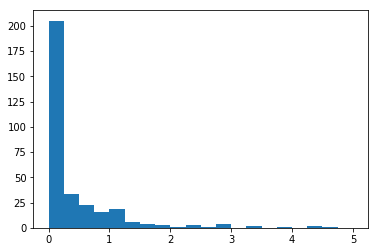

In [11]:
#df_test["lifetime"] = df["Time_stamp_y"] - df["Time_stamp_x"]
print(type(df_test["Time_stamp_x"][0]))
print(type(df_test["Time_stamp_y"][0]))

from math import isnan

lifetime = []
for index, row in df_test.iterrows():
#    if not isinstance(row["Time_stamp_x"], float):
#        print(row["Time_stamp_x"])
#    if not isinstance(row["Time_stamp_y"], float):
#        print(row["Time_stamp_y"])
    dummy = row["Time_stamp_y"] - row["Time_stamp_x"]
    # if isnan(lifetime):
    #    print(row["Time_stamp_y"], row["Time_stamp_x"])
    lifetime.append(dummy)
    
df_test["lifetime"] = lifetime

df_test = df_test.dropna(how="any")
#print(df_test[["Time_stamp_x","Time_stamp_y","lifetime"]])

lifetimes = df_test["lifetime"]
print(len(lifetimes))
print(np.mean(lifetimes))
print(np.std(lifetimes))

import matplotlib.pyplot as plt
plt.hist(df_test["lifetime"], range=(0,5), bins=20)
plt.show()

In [12]:
test = df_test['Time Submission'][1:20]

for t in test:
    count = 0
    for k in df['Time']:
            if k <= t:
                count += 1
    print(count)

1170
6629
6858
8310
10944
16794
21711
22321
41683
41718
41830
41894
41906
41930
41969
42034
42294
42312
42489


In [13]:
df_test

,Time_stamp_x,Type_x,OrderID,Size Submission,Price Submission,Direction_x,Time Submission,Ask Price 1 Submission,Ask Size 1 Submission,Bid Price 1 Submission,...,Bid Size 3 Cancellation,Ask Price 4 Cancellation,Ask Size 4 Cancellation,Bid Price 4 Cancellation,Bid Size 4 Cancellation,Ask Price 5 Cancellation,Ask Size 5 Cancellation,Bid Price 5 Cancellation,Bid Size 5 Cancellation,lifetime
0,34400.045403,1.0,21748178,400.0,2239900.0,-1.0,2012-06-21 09:33:20.045403,2239900.0,400.0,2236000.0,...,61,2242000,200,2233900,200,2242500,50,2232500,10,0.250557
1,34406.544100,1.0,21866417,400.0,2239600.0,-1.0,2012-06-21 09:33:26.544100,2239600.0,500.0,2236500.0,...,507,2242500,50,2235000,94,2242900,30,2234900,50,2.781919
2,35153.192597,1.0,35085399,400.0,2237400.0,-1.0,2012-06-21 09:45:53.192597,2237100.0,1.0,2235100.0,...,100,2237500,100,2234100,100,2238700,29,2234000,100,0.001130
3,35194.067921,1.0,35699321,400.0,2237300.0,-1.0,2012-06-21 09:46:34.067921,2237300.0,400.0,2235500.0,...,50,2238600,100,2234700,100,2238700,29,2234100,100,8.520380
4,35414.485101,1.0,38755648,6.0,2239900.0,-1.0,2012-06-21 09:50:14.485101,2239900.0,6.0,2237600.0,...,113,2240300,13,2236900,100,2240400,15,2236600,975,5.068727
5,35699.123211,1.0,42650801,400.0,2243800.0,-1.0,2012-06-21 09:54:59.123211,2243800.0,521.0,2241600.0,...,135,2244200,16,2241300,19,2244400,150,2241200,100,0.320575
6,36275.740195,1.0,53304490,4.0,2236000.0,-1.0,2012-06-21 10:04:35.740196,2236000.0,4.0,2235000.0,...,20,2236700,120,2233400,100,2236800,117,2232700,100,0.423782
7,36723.703099,1.0,61021811,2.0,2235900.0,-1.0,2012-06-21 10:12:03.703099,2235900.0,2.0,2234700.0,...,19,2237000,19,2234000,16,2237100,100,2233900,100,0.003245
8,36841.146857,1.0,62393340,3.0,2235000.0,-1.0,2012-06-21 10:14:01.146857,2235000.0,3.0,2234200.0,...,400,2235700,100,2232900,19,2235900,119,2232400,100,1.468323
9,39169.996197,1.0,89131188,200.0,2257400.0,-1.0,2012-06-21 10:52:49.996197,2257300.0,18.0,2254600.0,...,6,2257700,300,2254300,100,2257800,50,2254200,26,0.001639


7922 0
222.51217874274175 1.50022764387648


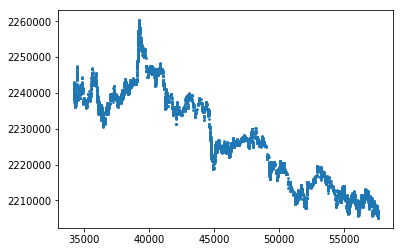

In [14]:
df_visExecute = GroupByOrderType(df,typeID=4)
df_invisExecute = GroupByOrderType(df,typeID=5)
#print(np.mean(df_visExecute["Time_stamp_y"]))
#print(df_visExecute["Time_stamp_y"][:100])
df_visExecute = df_visExecute.dropna(how="any")
df_invisExecute = df_invisExecute.dropna(how="any")

print(len(df_visExecute["Price Submission"]), len(df_invisExecute["Price Submission"]))
price = df_visExecute["Price Submission"]
print(np.mean(price)/10000, np.std(price)/10000)

plt.scatter(df_visExecute["Time_stamp_y"], df_visExecute["Price Submission"], s=3)
plt.scatter(df_invisExecute["Time_stamp_y"], df_invisExecute["Price Submission"], s=3)
plt.show()

In [15]:
df_submitted = GroupByOrderType(df,typeID=1)
df_submitted[["Time_stamp_x","Time_stamp_y"]].head(10)

,Time_stamp_x,Time_stamp_y
0,34200.189608,34200.189608
1,34200.189608,34200.189608
2,34200.189608,34200.189608
3,34200.189608,34200.189608
4,34200.189608,34200.189608
5,34200.189608,34200.189608
6,34200.189608,34200.189608
7,34200.189608,34200.189608
8,34200.189608,34200.189608
9,34200.189608,34200.189608



340
340
340


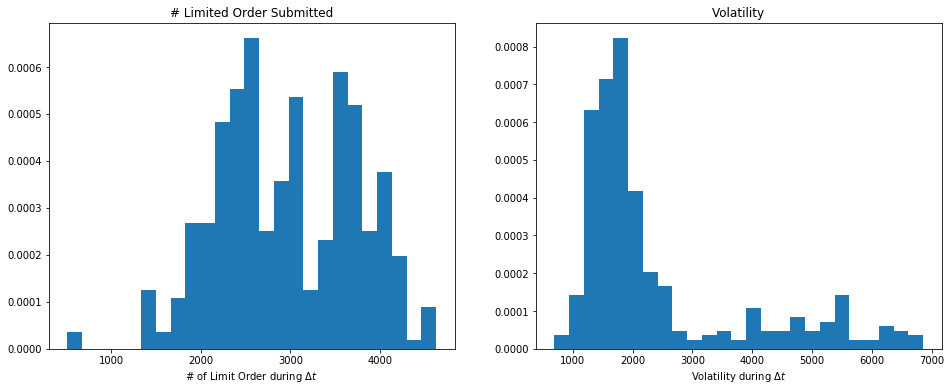

In [16]:
dt = 15*60

### We need the submission times of all our canceled orders
canceled_order_submission_times = df_test[["OrderID","Time_stamp_x"]]

### Now we need to gather all of the executed order prices between the aboves times and dt
norders = []
volts = []
for index, row in canceled_order_submission_times.iterrows():
    t = row["Time_stamp_x"]
    submitted_order = df_submitted[(df_submitted["Time_stamp_x"] > t-dt) & (df_submitted["Time_stamp_x"] < t)]
    executed_order = df_visExecute[(df_visExecute["Time_stamp_y"] > t-dt) & (df_visExecute["Time_stamp_y"] < t)]
    norder = len(submitted_order["OrderID"])
    volt = np.std(executed_order["Price Submission"])
    norders.append(norder)
    #print(norder)
    volts.append(volt)
    #print(len(executed_order), volt)
    
print()
print(len(norders))
print(len(volts))
print(len(df_test["OrderID"]))

fig, (ax,bx) = plt.subplots(1,2, figsize=(16,6))
ax.hist(norders, bins=25, normed=True)
bx.hist(volts, bins=25, normed=True)

ax.set_title("# Limited Order Submitted")
ax.set_xlabel(r"# of Limit Order during $\Delta{t}$")
bx.set_title("Volatility")
bx.set_xlabel(r"Volatility during $\Delta{t}$")
plt.show()

340 340


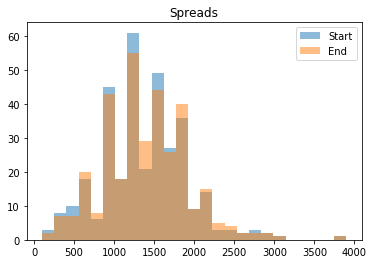

In [17]:
### Want to know the effective spread when each canceled order is submitted
spreads_start = []
spreads_end = []
for index, row in df_test.iterrows():
    spread_start = row["Ask Price 1 Submission"] - row["Bid Price 1 Submission"]
    spreads_start.append(spread_start)
    spread_end = row["Ask Price 1 Cancellation"] - row["Bid Price 1 Cancellation"]
    spreads_end.append(spread_end)

print(len(spreads_start), len(spreads_end))
plt.hist(spreads_start, bins=25, alpha=0.5, label="Start")
plt.hist(spreads_end, bins=25, alpha=0.5, label="End")
plt.title("Spreads")
plt.legend(loc="upper-right")
plt.show()

34400.2959607 57529.9353297


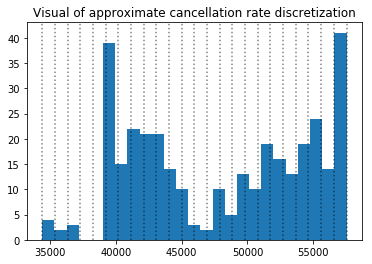

In [18]:
### Determine the cancellation rate during dt
plt.hist(df_test["Time_stamp_y"], bins=25)
start = df_test["Time_stamp_y"].min()
end = df_test["Time_stamp_y"].max()
print(start, end)
n = (end-start)/dt
Dt = np.linspace(start,end,n)
for i in Dt:
    plt.axvline(i, ls=":", color="k", alpha=0.5)
plt.title("Visual of approximate cancellation rate discretization")
plt.show()

Cancellation Ratio during dt:
[ 0.00439384]
Cancellation Rate:
[ 0.01452991]


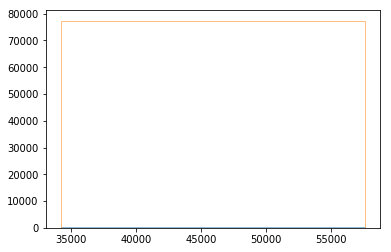

In [19]:
start_of_day = 9.5*3600 # 9:30 AM
end_of_day = 16*3600 # 4 PM
dt = 6.5*3600
n = (end_of_day - start_of_day)/dt
bins = np.linspace(start_of_day, end_of_day, n+1)
#print(dt)
#print(bins)
cancelled = plt.hist(df_test["Time_stamp_y"], bins=bins, alpha=0.5, histtype="step")
submitted = plt.hist(df_submitted["Time_stamp_x"], bins=bins, alpha=0.5, histtype="step")

print("Cancellation Ratio during dt:")
cancellation_ratio_during_dt = cancelled[0]/submitted[0]
print(cancellation_ratio_during_dt)

print("Cancellation Rate:")
cancellation_rate = cancelled[0]/dt
print(cancellation_rate)

In [20]:
len(set(df[(df['Type']==2)]['OrderID'].tolist()))

422

In [21]:
ks = [1,2,3,4,5,7]
for k in ks:
    print(len(set(df[(df['Type']==k)]['OrderID'].tolist())))

77381
422
66685
6993
1
0


In [22]:
df_test.columns

Index(['Time_stamp_x', 'Type_x', 'OrderID', 'Size Submission',
       'Price Submission', 'Direction_x', 'Time Submission',
       'Ask Price 1 Submission', 'Ask Size 1 Submission',
       'Bid Price 1 Submission', 'Bid Size 1 Submission',
       'Ask Price 2 Submission', 'Ask Size 2 Submission',
       'Bid Price 2 Submission', 'Bid Size 2 Submission',
       'Ask Price 3 Submission', 'Ask Size 3 Submission',
       'Bid Price 3 Submission', 'Bid Size 3 Submission',
       'Ask Price 4 Submission', 'Ask Size 4 Submission',
       'Bid Price 4 Submission', 'Bid Size 4 Submission',
       'Ask Price 5 Submission', 'Ask Size 5 Submission',
       'Bid Price 5 Submission', 'Bid Size 5 Submission', 'Time_stamp_y',
       'Type_y', 'Size Cancellation', 'Price Cancellation', 'Direction_y',
       'Time Cancellation', 'Ask Price 1 Cancellation',
       'Ask Size 1 Cancellation', 'Bid Price 1 Cancellation',
       'Bid Size 1 Cancellation', 'Ask Price 2 Cancellation',
       'Ask Size 2 Cancel

In [23]:
data = df_test[["OrderID","Time Submission","Direction_x","Price Submission","Size Submission",
                "Time Cancellation","lifetime","Size Cancellation",
                "Ask Price 1 Submission","Bid Price 1 Submission","Ask Price 1 Cancellation","Bid Price 1 Cancellation"]]
data["Effective Spread Submission"] = data['Ask Price 1 Submission'] - data['Bid Price 1 Submission']
data["Effective Spread Cancellation"] = data['Ask Price 1 Cancellation'] - data['Bid Price 1 Cancellation']
data["Volatility"] = volts
data["Number of Orders Submitted"] = norders
#len(data.index)
data.tail(10)

,OrderID,Time Submission,Direction_x,Price Submission,Size Submission,Time Cancellation,lifetime,Size Cancellation,Ask Price 1 Submission,Bid Price 1 Submission,Ask Price 1 Cancellation,Bid Price 1 Cancellation,Effective Spread Submission,Effective Spread Cancellation,Volatility,Number of Orders Submitted
330,276016423,2012-06-21 15:50:56.916982,1.0,2208200.0,200.0,2012-06-21 15:50:56.918255000,0.001274,100,2210200.0,2209000.0,2210100,2209000,1200.0,1100,1325.463387,4101
331,276213514,2012-06-21 15:51:09.082929,1.0,2209100.0,200.0,2012-06-21 15:51:09.582150000,0.499221,100,2210800.0,2209900.0,2210800,2209900,900.0,900,1270.486642,4083
332,278443627,2012-06-21 15:52:56.060809,-1.0,2207800.0,200.0,2012-06-21 15:52:56.063799999,0.002991,100,2207100.0,2205500.0,2207100,2205500,1600.0,1600,1687.462388,4206
333,279383340,2012-06-21 15:53:47.195869,1.0,2205100.0,300.0,2012-06-21 15:53:47.196338000,0.000468,200,2206700.0,2206100.0,2206700,2206100,600.0,600,1870.723191,4130
334,280776581,2012-06-21 15:55:04.142751,1.0,2207100.0,200.0,2012-06-21 15:55:04.682464000,0.539713,100,2208800.0,2207900.0,2208800,2208200,900.0,600,1960.481705,4003
335,280821524,2012-06-21 15:55:04.883042,1.0,2207000.0,200.0,2012-06-21 15:55:04.982408000,0.099366,100,2208800.0,2208200.0,2208800,2208200,600.0,600,1969.590833,4008
336,280940784,2012-06-21 15:55:06.383174,1.0,2207400.0,200.0,2012-06-21 15:55:06.461035000,0.077860,100,2209600.0,2208500.0,2209600,2208500,1100.0,1100,1968.083299,4016
337,280943766,2012-06-21 15:55:06.483060,1.0,2207300.0,200.0,2012-06-21 15:55:06.817562000,0.334502,100,2209600.0,2208500.0,2209600,2208500,1100.0,1100,1968.083299,4018
338,281835804,2012-06-21 15:55:39.770214,-1.0,2209100.0,200.0,2012-06-21 15:55:39.770757000,0.000542,100,2208600.0,2207100.0,2208600,2207100,1500.0,1500,1973.120273,3974
339,285251964,2012-06-21 15:58:49.256089,-1.0,2208800.0,200.0,2012-06-21 15:58:49.935330000,0.679241,100,2207500.0,2206800.0,2207500,2206900,700.0,600,1803.909668,3952


In [24]:
data.to_csv("AMZN_cancelledOrders.csv")

Text(0,0.5,'')

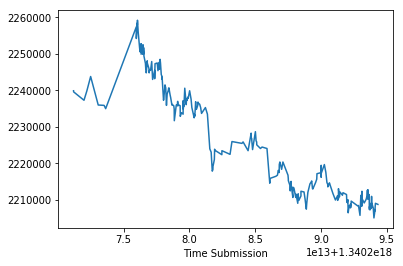

In [25]:
## plotting...
x = data['Time Submission']
y = data['Price Submission']
plt.plot(x,y)
plt.xlabel("Time Submission")
plt.ylabel("")